In [1]:
from factor_analysis import *

# rqfactor 其他算子
from rqfactor import Factor, REF, MA, SUM, CS_ZSCORE,STD,PCT_CHANGE,CORR,DELTA,MAX,MIN
from rqfactor.extension import UserDefinedLeafFactor

# 文件输出
import pickle

# 关闭警告
import warnings
warnings.filterwarnings("ignore")
import logging
logging.getLogger().setLevel(logging.ERROR)

In [2]:
# 研究时间
start_date = '2018-01-01'   
end_date = '2023-01-01'       
# 研究标的
index_item = '000852.XSHG'            # 【example】：全A 000985.XSHG 中证1000 000852.XSHG

# 股票池
index_fix = INDEX_FIX(start_date,end_date,index_item)
# 获取日期 和 标的
stock_list = index_fix.columns.tolist()
date_list = index_fix.index.tolist()

### 1 因子库构建

#### 1.1 算子式构建

In [3]:
# 基本面因子
cfoa_mrq = Factor('cash_flow_from_operating_activities_mrq_0')/Factor('total_assets_mrq_0')
atdy_mrq = Factor('operating_revenue_mrq_0')/Factor('total_assets_mrq_0') - Factor('operating_revenue_mrq_4')/Factor('total_assets_mrq_4')
ccr_mrq = Factor('cash_flow_from_operating_activities_mrq_0')/Factor('current_liabilities_mrq_0')
op_q_yoy_mrq = (Factor('profit_from_operation_mrq_0') - Factor('profit_from_operation_mrq_4'))/ABS(Factor('profit_from_operation_mrq_4'))
dp_ttm = Factor('dividend_yield_ttm')
opr_mrq = Factor('profit_from_operation_mrq_0') / Factor('operating_revenue_mrq_0')

# 量价因子
HIGH = Factor('high')
LOW = Factor('low')
OPEN = Factor('open')
CLOSE = Factor('close')
VOLUME = Factor('volume')
TURNOVER = Factor('total_turnover')

def turnover_rate(order_book_ids,start_date,end_date):
    return get_turnover_rate(order_book_ids,start_date,end_date,fields='today').today.unstack('order_book_id').reindex(columns=order_book_ids,index =pd.to_datetime(get_trading_dates(start_date,end_date)))

DAILY_TURNOVER_RATE = UserDefinedLeafFactor('DAILY_TURNOVER_RATE',turnover_rate)

# 流动性因子
liq_turn_avg = MA(DAILY_TURNOVER_RATE, 20)
liq_turn_std = STD(DAILY_TURNOVER_RATE, 20)
liq_zamount = MA(TURNOVER, 20)/STD(TURNOVER, 20)

# 量价相关性
corr_price_turn = CORR(CLOSE, DAILY_TURNOVER_RATE, 20)

# 波动率
vol_highlow_std = STD(HIGH/LOW, 20)
vol_up_shadow_std = STD((HIGH-MAX(OPEN,CLOSE))/HIGH, 20)

# 动量
month_day,year_day = 20,252
mmt_normal_M = CLOSE / REF(CLOSE, month_day) - 1
mmt_normal_A = REF(CLOSE, month_day) / REF(CLOSE, year_day) - 1

factor_dict = {
               }

factor_dict = {'cfoa_mrq':cfoa_mrq,
               'atdy_mrq':atdy_mrq,
               'ccr_mrq':ccr_mrq,
               'op_q_yoy_mrq':op_q_yoy_mrq,
               'dp_ttm':dp_ttm,
               'opr_mrq':opr_mrq,
               'liq_turn_avg':liq_turn_avg * -1,
               'liq_turn_std':liq_turn_std * -1,
               'liq_zamount':liq_zamount,
               'corr_price_turn':corr_price_turn * -1,
               'vol_highlow_std':vol_highlow_std * -1,
               'vol_up_shadow_std':vol_up_shadow_std * -1,
               'mmt_normal_M':mmt_normal_M * -1,
               'mmt_normal_A':mmt_normal_A,}

#### 1.2 因子值获取 & 数据清洗

In [4]:
value_dict = {}
for k,v in factor_dict.items():
    # 获取因子
    df = execute_factor(v,stock_list,start_date,end_date)
    # 因子清洗
    df = data_clean(df,index_fix,index_item)
    # 数据存储
    value_dict[k] = df
    
# 存储
pickle.dump(value_dict,open('value_dict.pkl','wb'))

剔除新股已构建
剔除ST已构建
剔除停牌已构建
剔除开盘涨停已构建
gen industry martix... 


100%|██████████| 1215/1215 [00:05<00:00, 233.51it/s]


In [5]:
value_dict = pd.read_pickle('./value_dict.pkl')

### 2 单因子检验

In [6]:
ic_df = pd.DataFrame(index = date_list)
ic_summary = pd.DataFrame()
for k,v in value_dict.items():    
    # 计算icir指标，T检验
    ic,ic_summary_temp = Quick_Factor_Return_N_IC(v,20,index_item,k)
    ic_df = pd.concat([ic_df,ic.to_frame(k)],axis = 1)
    ic_summary = pd.concat([ic_summary,ic_summary_temp.set_index('name')],axis = 0)

# 存储
ic_df.to_pickle('ic_df.pkl')
ic_summary.to_csv('ic_summary.csv')

{'name': 'cfoa_mrq', 'IC mean': 0.0217, 'IC std': 0.0471, 'IR': 0.4595, 'IR_ly': 0.7261, 'IC>0': 0.6636, 'ABS_IC>2%': 0.6636, 't_stat': 15.8828}
{'name': 'atdy_mrq', 'IC mean': 0.0231, 'IC std': 0.0539, 'IR': 0.4295, 'IR_ly': 0.3754, 'IC>0': 0.672, 'ABS_IC>2%': 0.7849, 't_stat': 14.8456}
{'name': 'ccr_mrq', 'IC mean': 0.0206, 'IC std': 0.0457, 'IR': 0.4513, 'IR_ly': 0.6792, 'IC>0': 0.6661, 'ABS_IC>2%': 0.6402, 't_stat': 15.6001}
{'name': 'op_q_yoy_mrq', 'IC mean': 0.0322, 'IC std': 0.0753, 'IR': 0.4272, 'IR_ly': 0.1984, 'IC>0': 0.6753, 'ABS_IC>2%': 0.8301, 't_stat': 14.7668}
{'name': 'dp_ttm', 'IC mean': 0.034, 'IC std': 0.0646, 'IR': 0.5268, 'IR_ly': 0.407, 'IC>0': 0.7163, 'ABS_IC>2%': 0.8711, 't_stat': 18.2101}
{'name': 'opr_mrq', 'IC mean': 0.0319, 'IC std': 0.0671, 'IR': 0.4754, 'IR_ly': 0.011, 'IC>0': 0.6594, 'ABS_IC>2%': 0.7473, 't_stat': 16.4355}
{'name': 'liq_turn_avg', 'IC mean': 0.0866, 'IC std': 0.1032, 'IR': 0.839, 'IR_ly': 0.9144, 'IC>0': 0.7891, 'ABS_IC>2%': 0.9021, 't_st

In [7]:
factor_names = ic_summary[ic_summary.IR >= 0.3].index.tolist()
# 此处我们卡IR大于0.3进行过滤，但其实可以看到部分因子在IR_1y已经出现明显的衰落。后续我们有新的指标加入，来评估该现象~
ic_summary.loc[factor_names].sort_values(by = 'IR',ascending = False)

,IC mean,IC std,IR,IR_ly,IC>0,ABS_IC>2%,t_stat
name,,,,,,,
liq_turn_std,0.0936,0.0912,1.0267,1.0082,0.8335,0.9004,35.4922
corr_price_turn,0.0612,0.0623,0.9822,0.7926,0.8351,0.8510,33.9542
liq_zamount,0.0517,0.0538,0.9609,0.7537,0.8301,0.7941,33.2162
vol_highlow_std,0.0770,0.0900,0.8555,0.8781,0.8050,0.8720,29.5748
liq_turn_avg,0.0866,0.1032,0.8390,0.9144,0.7891,0.9021,29.0017
vol_up_shadow_std,0.0721,0.0896,0.8055,0.8406,0.7732,0.8795,27.8458
mmt_normal_M,0.0556,0.0901,0.6173,0.6864,0.7305,0.8544,21.3410
dp_ttm,0.0340,0.0646,0.5268,0.4070,0.7163,0.8711,18.2101
opr_mrq,0.0319,0.0671,0.4754,0.0110,0.6594,0.7473,16.4355


#### 2.1 累计IC

In [8]:
# 累计ic图
def cumic(name,ic_df):
    """
    :param name: 因子名称 -> list 
    :param ic_df: ic序列表 -> dataframe 
    :return fig: 累计ic图 -> plot
    """
    ic_df[name].cumsum().plot(figsize = (10,6))

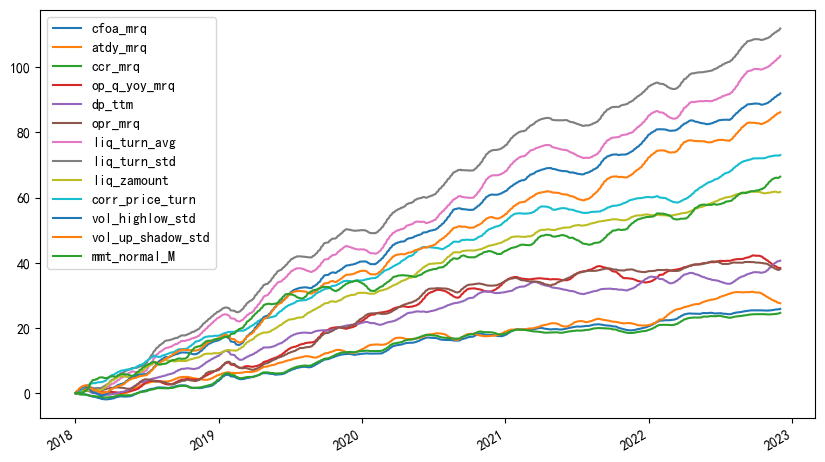

In [9]:
cumic(factor_names,ic_df)

In [10]:
ic_df.count()

cfoa_mrq             1195
atdy_mrq             1195
ccr_mrq              1195
op_q_yoy_mrq         1195
dp_ttm               1195
opr_mrq              1195
liq_turn_avg         1195
liq_turn_std         1195
liq_zamount          1195
corr_price_turn      1195
vol_highlow_std      1195
vol_up_shadow_std    1195
mmt_normal_M         1195
mmt_normal_A         1195
dtype: int64

In [11]:
ic_df[factor_names].corr()

,cfoa_mrq,atdy_mrq,ccr_mrq,op_q_yoy_mrq,dp_ttm,opr_mrq,liq_turn_avg,liq_turn_std,liq_zamount,corr_price_turn,vol_highlow_std,vol_up_shadow_std,mmt_normal_M
cfoa_mrq,1.000000,0.414693,0.950851,0.520256,0.479546,0.497078,0.280627,0.293622,0.202463,0.135480,0.365788,0.372366,-0.062712
atdy_mrq,0.414693,1.000000,0.370850,0.760707,-0.079734,0.428690,-0.124483,-0.118924,0.032171,-0.055909,-0.031872,-0.007669,-0.255470
ccr_mrq,0.950851,0.370850,1.000000,0.499961,0.482570,0.544257,0.290562,0.289981,0.161388,0.135147,0.336254,0.343473,-0.071849
op_q_yoy_mrq,0.520256,0.760707,0.499961,1.000000,0.074014,0.742865,-0.091719,-0.051552,0.198571,0.031312,0.043570,0.054579,-0.207549
dp_ttm,0.479546,-0.079734,0.482570,0.074014,1.000000,0.208547,0.611068,0.582017,0.115811,0.176334,0.631121,0.648002,0.069321
opr_mrq,0.497078,0.428690,0.544257,0.742865,0.208547,1.000000,-0.069317,-0.012590,0.262596,0.135850,0.048565,0.035437,-0.147040
liq_turn_avg,0.280627,-0.124483,0.290562,-0.091719,0.611068,-0.069317,1.000000,0.973009,0.209281,0.405787,0.859040,0.873370,0.210681
liq_turn_std,0.293622,-0.118924,0.289981,-0.051552,0.582017,-0.012590,0.973009,1.000000,0.404888,0.496993,0.879553,0.865976,0.276295
liq_zamount,0.202463,0.032171,0.161388,0.198571,0.115811,0.262596,0.209281,0.404888,1.000000,0.601840,0.373819,0.265962,0.384929
corr_price_turn,0.135480,-0.055909,0.135147,0.031312,0.176334,0.135850,0.405787,0.496993,0.601840,1.000000,0.291527,0.290294,0.472776


### 3 多重共共线性检验
#### 3.1 相关性统计
##### 3.1.1 因子IC相关性统计

In [12]:
# 热力图    
def hot_corr(name,ic_df):
    """
    :param name: 因子名称 -> list 
    :param ic_df: ic序列表 -> dataframe 
    :return fig: 热力图 -> plt
    """
    ax = plt.subplots(figsize=(len(name), len(name)))#调整画布大小
    ax = sns.heatmap(ic_df[name].corr(),vmin=0.4, square=True, annot= True,cmap = 'Blues')   #annot=True 表示显示系数
    plt.title('Factors_IC_CORRELATION')
    # 设置刻度字体大小
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

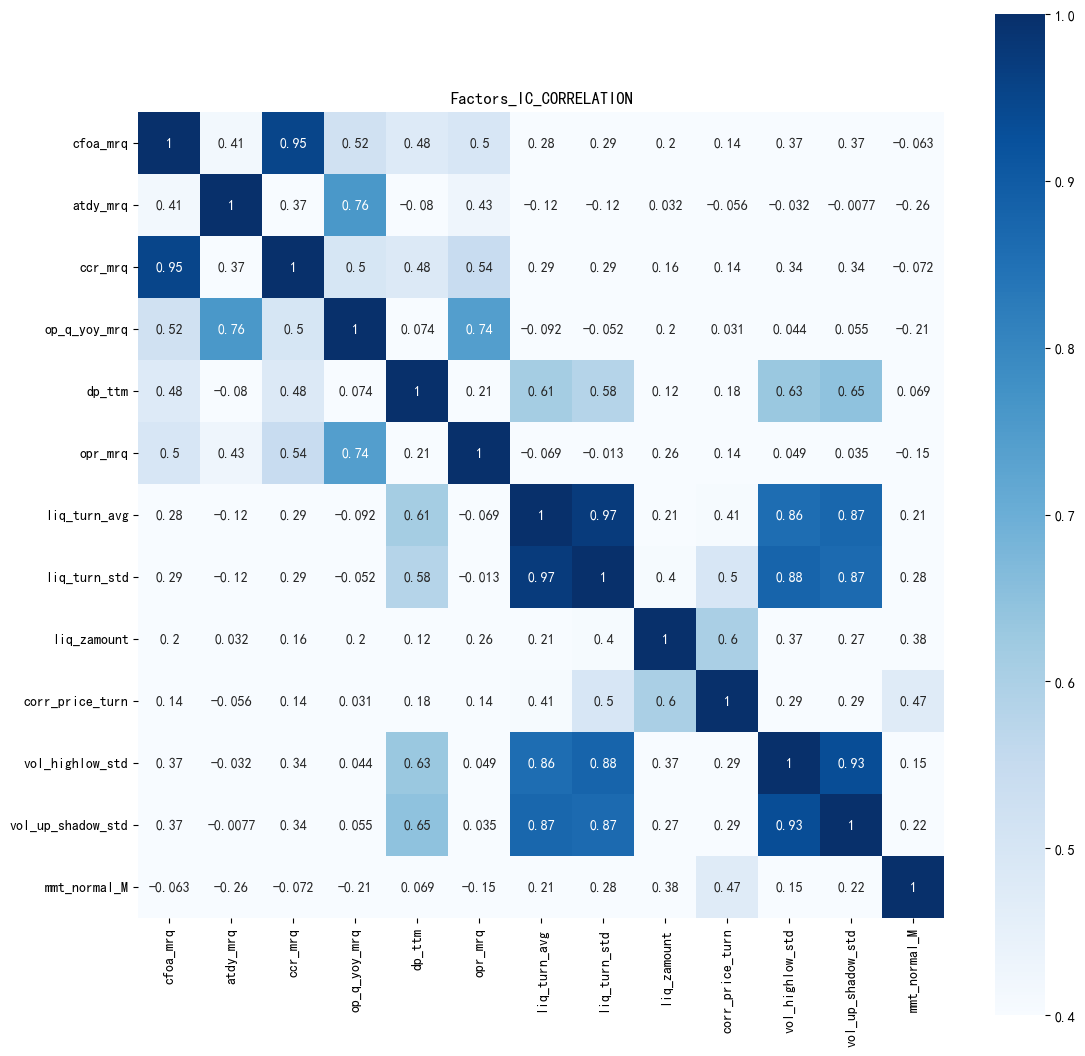

In [13]:
# ic序列相关性
hot_corr(factor_names,ic_df)

##### 3.1.2 因子值相关性统计

In [14]:
# 因子值相关性
value_df = pd.DataFrame(index = value_dict[factor_names[0]].stack().index)
for i in factor_names:
    value_df[i] = value_dict[i].stack()
value_df.dropna()
value_df.columns = factor_names
value_df.head()

cfoa_mrq  atdy_mrq   ccr_mrq  op_q_yoy_mrq    dp_ttm  \
datetime                                                                       
2018-01-02 000010.XSHE  0.127313  1.826817  0.099466      1.706450 -1.142389   
           000011.XSHE  0.660750  2.135730  0.296694      1.494684  0.688768   
           000016.XSHE -1.935531 -0.632822 -0.929461      1.262487 -1.553907   
           000018.XSHE -1.434536 -1.264260 -0.699314     -0.282902  0.534118   
           000036.XSHE  0.360274  0.572447  0.320169     -0.683542  1.878261   

                         opr_mrq  liq_turn_avg  liq_turn_std  liq_zamount  \
datetime                                                                    
2018-01-02 000010.XSHE  1.694795     -0.969004     -0.592612     0.303908   
           000011.XSHE  0.678643     -1.133183     -0.736401     0.400212   
           000016.XSHE -1.132690      0.136408     -0.018221    -0.457035   
           000018.XSHE -0.505902     -0.168539      0.080227     1.030297   
           000036.XSHE  1.466957      0.033555     -0.066872    -0.394273   

                        corr_price_turn  vol_highlow_std  vol_up_shadow_std  \
datetime                                                                      
2018-01-02 000010.XSHE        -0.671786        -0.273014          -0.652485   
           000011.XSHE        -0.662591         0.719661          -0.094730   
           000016.XSHE         0.064075        -0.815398          -0.718698   
           000018.XSHE         2.210190         0.452594           1.325303   
           000036.XSHE        -1.103284         0.589852           0.763878   

                        mmt_normal_M  
datetime                              
2018-01-02 000010.XSHE     -1.595369  
           000011.XSHE     -0.500454  
           000016.XSHE      0.739026  
           000018.XSHE      2.104322  
           000036.XSHE     -0.826386

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 [Text(0, 0.5, 'cfoa_mrq'),
  Text(0, 1.5, 'atdy_mrq'),
  Text(0, 2.5, 'ccr_mrq'),
  Text(0, 3.5, 'op_q_yoy_mrq'),
  Text(0, 4.5, 'dp_ttm'),
  Text(0, 5.5, 'opr_mrq'),
  Text(0, 6.5, 'liq_turn_avg'),
  Text(0, 7.5, 'liq_turn_std'),
  Text(0, 8.5, 'liq_zamount'),
  Text(0, 9.5, 'corr_price_turn'),
  Text(0, 10.5, 'vol_highlow_std'),
  Text(0, 11.5, 'vol_up_shadow_std'),
  Text(0, 12.5, 'mmt_normal_M')])

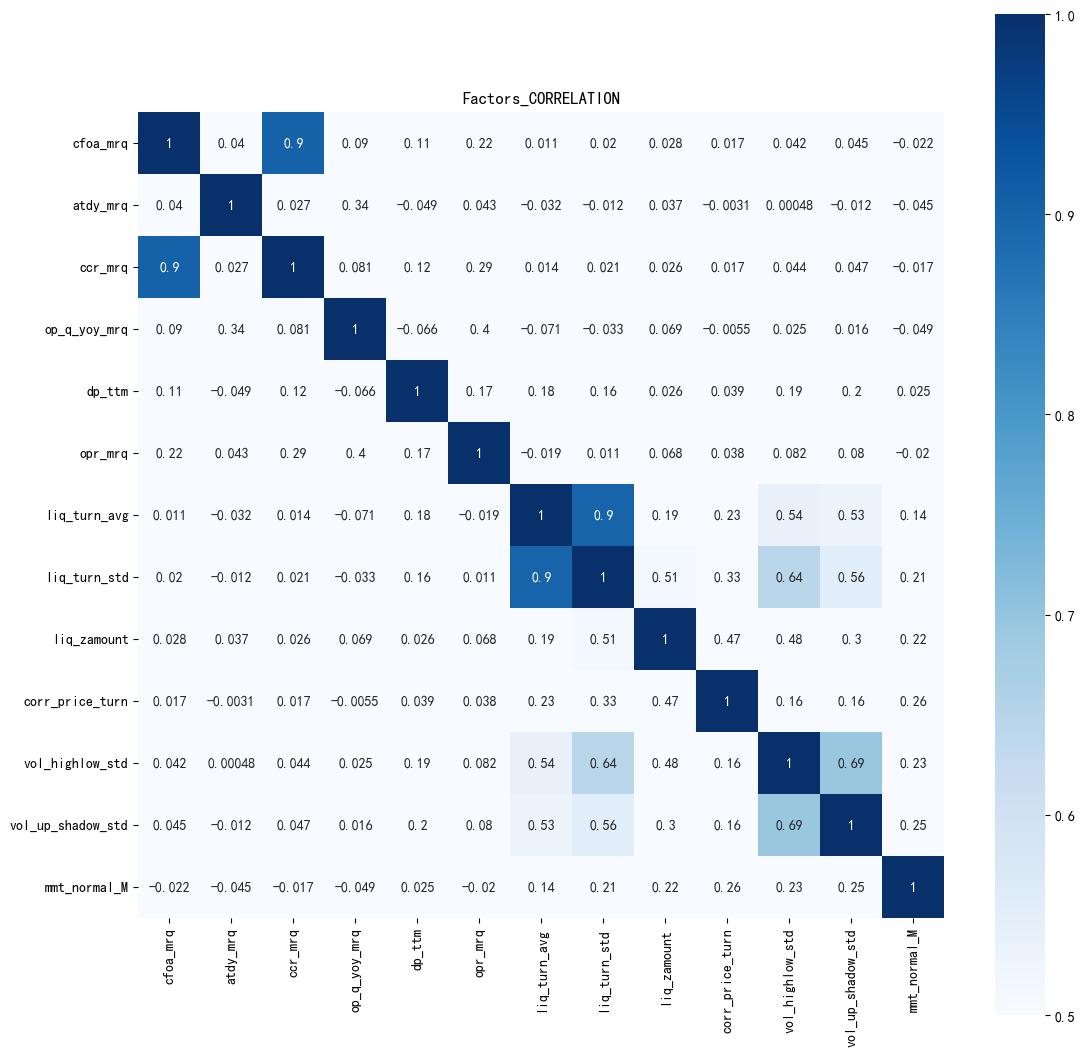

In [15]:
ax = plt.subplots(figsize=(len(factor_names), len(factor_names)))#调整画布大小
ax = sns.heatmap(value_df.corr(),vmin= 0.5, square=True, annot= True,cmap = 'Blues')#画热力图   annot=True 表示显示系数
plt.title('Factors_CORRELATION')
# 设置刻度字体大小
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

#### 3.2 VIF检验

In [16]:
# VIF检验
ic_df_pass = ic_df[factor_names]
VIF = {}
for i in tqdm(ic_df_pass.columns.tolist()):
    y = ic_df_pass[i]
    x = ic_df_pass.drop(i,axis = 1)
    VIF[i] = 1 / (1 - sm.OLS(y.astype(float),x.astype(float),hasconst=False, missing='drop').fit().rsquared)

VIF = pd.DataFrame([VIF]).T
VIF.columns = ['VIF']
VIF.sort_values(by = 'VIF',ascending=False)

100%|██████████| 13/13 [00:00<00:00, 619.29it/s]


,VIF
liq_turn_std,187.987123
liq_turn_avg,155.256426
vol_highlow_std,21.482094
vol_up_shadow_std,18.736995
ccr_mrq,16.216966
cfoa_mrq,16.023037
liq_zamount,13.134072
op_q_yoy_mrq,5.974069
corr_price_turn,4.809704
opr_mrq,4.065481


### 4 多重共线性处理

#### 4.1 高相关性处理

In [17]:
ic_df

,cfoa_mrq,atdy_mrq,ccr_mrq,op_q_yoy_mrq,dp_ttm,opr_mrq,liq_turn_avg,liq_turn_std,liq_zamount,corr_price_turn,vol_highlow_std,vol_up_shadow_std,mmt_normal_M,mmt_normal_A
2018-01-02,-0.038978,0.022473,-0.059047,0.064208,0.011150,-0.021996,0.148555,0.154059,0.055306,0.103220,0.136834,0.198924,0.109416,-0.042175
2018-01-03,-0.025391,0.038379,-0.038437,0.084216,0.021239,0.008764,0.168437,0.163284,0.034698,0.073172,0.170196,0.202212,0.073477,-0.009423
2018-01-04,-0.025400,0.050914,-0.031132,0.098173,0.036444,0.053094,0.170101,0.153154,-0.013514,0.074545,0.154789,0.200757,0.011666,0.027285
2018-01-05,-0.014677,0.044694,-0.016408,0.119891,0.036362,0.064887,0.131920,0.102154,-0.046252,0.043449,0.111458,0.164560,-0.052159,0.056166
2018-01-08,-0.021392,0.049910,-0.016946,0.096022,0.047689,0.045868,0.128735,0.103643,-0.038099,0.050460,0.105597,0.154116,-0.046327,0.048399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
def corr_line(ic_df,low = 0.8,high = 1):
    ## 高相关性分析
    factor_corr = pd.DataFrame(ic_df.dropna().corr().stack())
    factor_corr.columns = ['CORRELATION']
    factor_corr.index.names = ['factor_a','factor_b']
    factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()

    return factor_corr

In [19]:
high_data = corr_line(ic_df[factor_names])
high_data

CORRELATION
factor_a        factor_b                      
cfoa_mrq        ccr_mrq               0.950851
liq_turn_avg    liq_turn_std          0.973009
                vol_highlow_std       0.859040
                vol_up_shadow_std     0.873370
liq_turn_std    vol_highlow_std       0.879553
                vol_up_shadow_std     0.865976
vol_highlow_std vol_up_shadow_std     0.932412

In [20]:
orth_wait = list(set(high_data.index.get_level_values(0)) | set(high_data.index.get_level_values(1)))
orth_wait

['vol_highlow_std',
 'cfoa_mrq',
 'vol_up_shadow_std',
 'liq_turn_avg',
 'ccr_mrq',
 'liq_turn_std']

In [21]:
corr_group = {0:['cfoa_mrq','ccr_mrq'],
              1:['liq_turn_avg','liq_turn_std','vol_highlow_std','vol_up_shadow_std']}

In [22]:
for i in list(corr_group.keys()):
    del_factors = ic_summary.loc[corr_group[i],'IR'].sort_values(ascending = False).index.tolist()[1:]
    for j in del_factors:
        factor_names.remove(j)
factor_names

['cfoa_mrq',
 'atdy_mrq',
 'op_q_yoy_mrq',
 'dp_ttm',
 'opr_mrq',
 'liq_turn_std',
 'liq_zamount',
 'corr_price_turn',
 'mmt_normal_M']

#### 4.2 中相关性处理

In [23]:
def corr_line(ic_df,low = 0.65,high = 1):
    ## 高相关性分析
    factor_corr = pd.DataFrame(ic_df.dropna().corr().stack())
    factor_corr.columns = ['CORRELATION']
    factor_corr.index.names = ['factor_a','factor_b']
    factor_corr = factor_corr[(factor_corr > low) & (factor_corr < high)].dropna().drop_duplicates()

    return factor_corr

In [24]:
middle_data = corr_line(ic_df[factor_names])
middle_data

,,CORRELATION
factor_a,factor_b,
atdy_mrq,op_q_yoy_mrq,0.760707
op_q_yoy_mrq,opr_mrq,0.742865


(array([0.5, 1.5, 2.5]),
 [Text(0, 0.5, 'opr_mrq'),
  Text(0, 1.5, 'op_q_yoy_mrq'),
  Text(0, 2.5, 'atdy_mrq')])

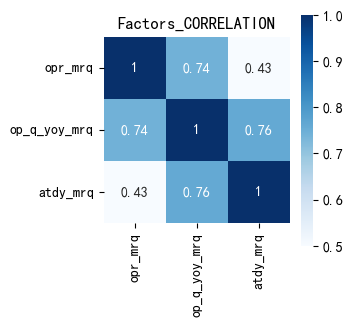

In [25]:
orth_wait = list(set(middle_data.index.get_level_values(0)) | set(middle_data.index.get_level_values(1)))
ax = plt.subplots(figsize=(len(orth_wait), len(orth_wait)))#调整画布大小
ax = sns.heatmap(ic_df[orth_wait].corr(),vmin=0.5, square=True, annot= True,cmap = 'Blues')#画热力图   annot=True 表示显示系数
plt.title('Factors_CORRELATION')
# 设置刻度字体大小
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

In [26]:
corr_group = {0:['opr_mrq','atdy_mrq','op_q_yoy_mrq']}

##### 4.2.1 正交化处理

In [27]:
# 正交化函数
def orth_quick(orth_list,value_dict):
        # 正交化函数
    def orth_function(orth,time_list):
        orth = orth.dropna()
        factor_names = orth.columns.tolist()
        factors_orthogonal = pd.DataFrame(columns = factor_names,index = orth.index)
        # 数据运行
        factors_orthogonalization = pd.DataFrame()
        for i in time_list:
            try:
                factor = orth.loc[i]
                factor = factor[factor_names]
                M = (factor.shape[0]-1)* np.cov(factor.T.astype(float))   # 矩阵M
                D,U = np.linalg.eig(M)                                    # 获取特征值和特征向量
                U = np.mat(U)                                             # 转换为np中的矩阵
                d = np.mat(np.diag(D**(-0.5)))                            # 对特征根元素开(-0.5)指数
                S = U * d * U.T                                           # 获取过度矩阵S
                factors_orthogonal_mat = np.mat(factor) * S               # 获取对称正交矩阵
                factors_orthogonal.loc[i].loc[factor.index,factor_names] = factors_orthogonal_mat   # 矩阵转为dataframe
            except:
                pass
        return factors_orthogonal
    
    # 确定最早和最晚的起止日期    
    common_start = max(value_dict[factor_name].index[0] for factor_name in orth_list)
    common_end = min(value_dict[factor_name].index[-1] for factor_name in orth_list)
    date_list = pd.to_datetime(get_trading_dates(common_start,common_end))
    # 计算股票名称的交集
    common_stocks = set.intersection(*[set(value_dict[factor_name].columns) for factor_name in orth_list])

    df = pd.DataFrame(index = pd.MultiIndex.from_product([date_list, common_stocks], names=["date", "order_book_id"]))

    for k in orth_list:
        df[k] = value_dict[k].stack()

    df = orth_function(df,date_list)
    df = df.sum(axis = 1).unstack('order_book_id')
    df = df.sub(df.mean(axis=1), axis=0).div(df.std(axis=1), axis=0)
    
    return df

In [28]:
factor_orth = orth_quick(corr_group[0],value_dict)
orth_name = 'orth(' + '+'.join(corr_group[0]) + ')'
ic,performance = Quick_Factor_Return_N_IC(factor_orth,20,index_item,orth_name)

{'name': 'orth(opr_mrq+atdy_mrq+op_q_yoy_mrq)', 'IC mean': 0.0385, 'IC std': 0.0745, 'IR': 0.5171, 'IR_ly': 0.273, 'IC>0': 0.6929, 'ABS_IC>2%': 0.8285, 't_stat': 17.8758}


In [29]:
# 合成后的因子表现会由于合成前的单个因子
ic_summary.loc[corr_group[0]]

,IC mean,IC std,IR,IR_ly,IC>0,ABS_IC>2%,t_stat
name,,,,,,,
opr_mrq,0.0319,0.0671,0.4754,0.0110,0.6594,0.7473,16.4355
atdy_mrq,0.0231,0.0539,0.4295,0.3754,0.6720,0.7849,14.8456
op_q_yoy_mrq,0.0322,0.0753,0.4272,0.1984,0.6753,0.8301,14.7668


In [30]:
# 加入合成因子IC
ic_df[orth_name] = ic

# 加入合成因子值
value_dict[orth_name] = factor_orth

# 合成队列剔除原始因子，加入合成因子
for i in orth_wait:
    factor_names.remove(i)

factor_names += [orth_name]
factor_names

['cfoa_mrq',
 'dp_ttm',
 'liq_turn_std',
 'liq_zamount',
 'corr_price_turn',
 'mmt_normal_M',
 'orth(opr_mrq+atdy_mrq+op_q_yoy_mrq)']

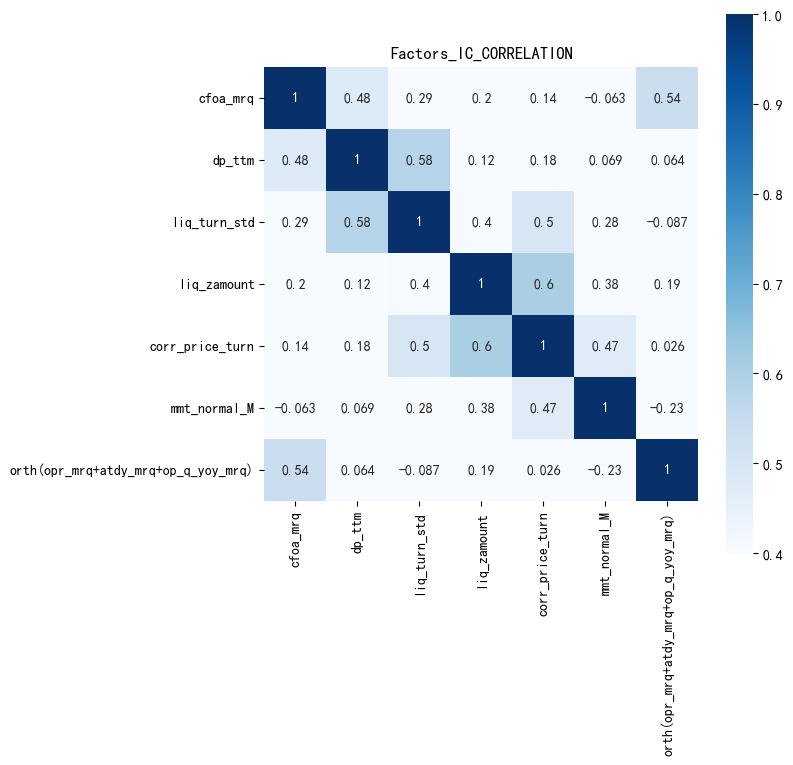

In [31]:
# ic序列相关性
hot_corr(factor_names,ic_df)

### 5 多因子合成

不同合成方法收益风险对比，参考《光大证券 EBQC因子综合质量因子》，更多合成方法可以参考《华泰金工 多因子合成方法》

课程的网站对应课件中均可下载。

#### 5.1 等权合成

In [32]:
ew_combo = pd.DataFrame()
for i in factor_names:
    ew_combo = ew_combo.add(value_dict[i],fill_value = 0)
ew_combo.to_pickle('ew_combo.pkl')

In [33]:
ic,performance = Quick_Factor_Return_N_IC(ew_combo,20,index_item,'ew_combo')

{'name': 'ew_combo', 'IC mean': 0.1002, 'IC std': 0.0802, 'IR': 1.249, 'IR_ly': 1.2029, 'IC>0': 0.8904, 'ABS_IC>2%': 0.9088, 't_stat': 43.1774}


In [34]:
ic_summary.loc[list(set(ic_summary.index.tolist())&set(factor_names))].sort_values(by = 'IR',ascending = False)

,IC mean,IC std,IR,IR_ly,IC>0,ABS_IC>2%,t_stat
name,,,,,,,
liq_turn_std,0.0936,0.0912,1.0267,1.0082,0.8335,0.9004,35.4922
corr_price_turn,0.0612,0.0623,0.9822,0.7926,0.8351,0.8510,33.9542
liq_zamount,0.0517,0.0538,0.9609,0.7537,0.8301,0.7941,33.2162
mmt_normal_M,0.0556,0.0901,0.6173,0.6864,0.7305,0.8544,21.3410
dp_ttm,0.0340,0.0646,0.5268,0.4070,0.7163,0.8711,18.2101
cfoa_mrq,0.0217,0.0471,0.4595,0.7261,0.6636,0.6636,15.8828


In [35]:
def get_buy_list(df,top_tpye = 'rank',rank_n = 100,quantile_q = 0.8):
    """
    :param df: 因子值 -> dataframe/unstack
    :param top_tpye: 选择买入队列方式，从['rank','quantile']选择一种方式 -> str
    :param rank_n: 值最大的前n只的股票 -> int
    :param quantile_q: 值最大的前n分位数的股票 -> float
    :return df: 买入队列 -> dataframe/unstack
    """
    if top_tpye == 'rank':
        df = df.rank(axis  = 1,ascending=False) <= rank_n
    elif top_tpye == 'quantiles':
        df = df.sub(df.quantiles(quantile_q,axis = 1),axis = 0) > 0
    else:
        print("select one from ['rank','quantile']")

    df = df.astype(int)
    df = df.replace(0,np.nan).dropna(how = 'all',axis = 1)
    
    return df


def get_bar(df):
    """
    :param df: 买入队列 -> dataframe/unstack
    :param benchmark: 基准指数 -> str
    :return ret: 基准的逐日收益 -> dataframe
    """
    start_date = get_previous_trading_date(df.index.min(),1).strftime('%F')
    end_date = df.index.max().strftime('%F')
    stock_list = df.columns.tolist()
    price_open = get_price(stock_list,start_date,end_date,fields=['open']).open.unstack('order_book_id')
    
    return price_open


def get_benchmark(df,benchmark = '000985.XSHG'):
    """
    :param df: 买入队列 -> dataframe/unstack
    :param benchmark: 基准指数 -> str
    :return ret: 基准的逐日收益 -> dataframe
    """
    start_date = get_previous_trading_date(df.index.min(),1).strftime('%F')
    end_date = df.index.max().strftime('%F')
    price_open = get_price([benchmark],start_date,end_date,fields=['open']).open.unstack('order_book_id')
    
    return price_open


def get_performance_analysis(account_result,name = ' ',rf = 0.03,benchmark_index = '000985.XSHG'):

    # 加入基准    
    performance = pd.concat([account_result['total_account_asset'].to_frame('strategy'),
                             get_benchmark(account_result,benchmark_index)],axis = 1)
    performance_net = performance.pct_change().dropna(how = 'all')                                # 清算至当日开盘
    performance_cumnet = (1 + performance_net).cumprod()
    performance_cumnet['alpha'] = performance_cumnet['strategy']/performance_cumnet[benchmark_index]
    performance_cumnet = performance_cumnet.fillna(1)

    # 指标计算
    performance_pct = performance_cumnet.pct_change().dropna()

    # 策略收益
    strategy_name,benchmark_name,alpha_name = performance_cumnet.columns.tolist() 
    Strategy_Final_Return = performance_cumnet[strategy_name].iloc[-1] - 1

    # 策略年化收益
    Strategy_Annualized_Return_EAR = (1 + Strategy_Final_Return) ** (252/len(performance_cumnet)) - 1

    # 基准收益
    Benchmark_Final_Return = performance_cumnet[benchmark_name].iloc[-1] - 1

    # 基准年化收益
    Benchmark_Annualized_Return_EAR = (1 + Benchmark_Final_Return) ** (252/len(performance_cumnet)) - 1

    # alpha 
    ols_result = sm.OLS(performance_pct[strategy_name] * 252 - rf, sm.add_constant(performance_pct[benchmark_name] * 252 - rf)).fit()
    Alpha = ols_result.params[0]

    # beta
    Beta = ols_result.params[1]

    # beta_2 = np.cov(performance_pct[strategy_name],performance_pct[benchmark_name])[0,1]/performance_pct[benchmark_name].var()
    # 波动率
    Strategy_Volatility = performance_pct[strategy_name].std() * np.sqrt(252)

    # 夏普
    Strategy_Sharpe = (Strategy_Annualized_Return_EAR - rf)/Strategy_Volatility

    # 下行波动率
    strategy_ret = performance_pct[strategy_name]
    Strategy_Down_Volatility = strategy_ret[strategy_ret < 0].std() * np.sqrt(252)

    # sortino
    Sortino = (Strategy_Annualized_Return_EAR - rf)/Strategy_Down_Volatility
    
    # 跟踪误差
    Tracking_Error = (performance_pct[strategy_name] - performance_pct[benchmark_name]).std() * np.sqrt(252)

    # 信息比率
    Information_Ratio = (Strategy_Annualized_Return_EAR - Benchmark_Annualized_Return_EAR)/Tracking_Error

    # 最大回测
    i = np.argmax((np.maximum.accumulate(performance_cumnet[benchmark_name]) 
                    - performance_cumnet[benchmark_name])
                    /np.maximum.accumulate(performance_cumnet[benchmark_name]))
    j = np.argmax(performance_cumnet[benchmark_name][:i])
    Max_Drawdown = (1-performance_cumnet[benchmark_name][i]/performance_cumnet[benchmark_name][j])

    # 卡玛比率
    Calmar = (Strategy_Annualized_Return_EAR)/Max_Drawdown

    # 超额收益
    Alpha_Final_Return = performance_cumnet[alpha_name].iloc[-1] - 1

    # 超额年化收益
    Alpha_Annualized_Return_EAR = (1 + Alpha_Final_Return) ** (252/len(performance_cumnet)) - 1

    # 超额波动率
    Alpha_Volatility = performance_pct[alpha_name].std() * np.sqrt(252)

    # 超额夏普
    Alpha_Sharpe = (Alpha_Annualized_Return_EAR - rf)/Alpha_Volatility

    # 超额最大回测
    i = np.argmax((np.maximum.accumulate(performance_cumnet[alpha_name]) 
                    - performance_cumnet[alpha_name])
                    /np.maximum.accumulate(performance_cumnet[alpha_name]))
    j = np.argmax(performance_cumnet[alpha_name][:i])
    Alpha_Max_Drawdown = (1-performance_cumnet[alpha_name][i]/performance_cumnet[alpha_name][j])

    # 胜率
    performance_pct['win'] = performance_pct[alpha_name] > 0
    Win_Ratio = performance_pct['win'].value_counts().loc[True] / len(performance_pct)

    # 盈亏比
    profit_lose = performance_pct.groupby('win')[alpha_name].mean()
    Profit_Lose_Ratio = abs(profit_lose[True]/profit_lose[False])
    

    result = {
        'Strategy_Final_Return':round(Strategy_Final_Return,4),
        'Strategy_Annualized_Return_EAR': round(Strategy_Annualized_Return_EAR,4),
        'Benchmark_Final_Return':round(Benchmark_Final_Return,4),
        'Benchmark_Annualized_Return_EAR': round(Benchmark_Annualized_Return_EAR,4),
        'Alpha':round(Alpha,4),
        'Beta':round(Beta,4),
        'Volatility':round(Strategy_Volatility,4),
        'Sharpe':round(Strategy_Sharpe,4),
        'Down_Volatility':round(Strategy_Down_Volatility,4),
        'Sortino':round(Sortino,4),
        'Tracking_Error':round(Tracking_Error,4),
        'Information_Ratio':round(Information_Ratio,4),
        'Max_Drawdown':round(Max_Drawdown,4),
        'Calmar': round(Calmar,4),
        'Alpha_Final_Return':round(Alpha_Final_Return,4),
        'Alpha_Annualized_Return_EAR': round(Alpha_Annualized_Return_EAR,4),
        'Alpha_Volatility':round(Alpha_Volatility,4),
        'Alpha_Sharpe':round(Alpha_Sharpe,4),
        'Alpha_Max_Drawdown':round(Alpha_Max_Drawdown,4),
        'Win_Ratio':round(Win_Ratio,4),
        'Profit_Lose_Ratio':round(Profit_Lose_Ratio,4)

    }


    # 回测图绘制
    import matplotlib.pyplot as plt
    
    x = performance_cumnet.index
    y1 = performance_cumnet['strategy']
    y2 = performance_cumnet[benchmark_index]
    y3 = performance_cumnet['alpha']


    fig, ax = plt.subplots()

    ax.plot(x, y1, label='strategy',color = 'darkred')
    ax.plot(x, y2, label=benchmark_index)
    ax.plot(x, y3, label='alpha')
    plt.title(name)

    # 调整子图的布局，留出空间给表格
    plt.subplots_adjust(right=1.4, top=1.1)
    # 创建一个额外的空白子图
    # 添加表格
    cell_text =  [['指标','数值']] + [list(result.items())][0]
    table = ax.table(cellText=cell_text, loc='right')

    # 调整表格的大小
    #table.scale(0.7, 0.7)

    # 设置单元格的属性
    for (i, j), cell in table.get_celld().items():
        if i == 0:  # 对第一行进行处理
            cell.set_text_props(fontsize=10, ha='center', va='center')  # 居中对齐
        elif j == 0:  # 对第一列进行处理
            cell.set_text_props(fontsize=10, ha='left', va='center')  # 左对齐
        else:
            cell.set_text_props(fontsize=10, ha='right', va='center')  # 右对齐

    # 设置行高
    for i in range(len(cell_text)):
        table._cells[(i, 0)].set_height(0.0454)
        table._cells[(i, 1)].set_height(0.0453)
    table.auto_set_column_width([0, 1])
    table.auto_set_font_size(False)

    # 显示图例
    ax.legend()
    plt.show()

    return result

In [36]:
# 不含涨跌停
def backtest(df_weight, change_n = 20, cash = 10000 * 1000, tax = 0.0005, other_tax = 0.0001, commission = 0.0002, min_fee = 5, cash_interest_yield = 0.02):

    # 基础参数
    inital_cash = cash                                                                                                            # 起始资金
    stock_holding_num_hist = 0                                                                                                    # 初始化持仓       
    buy_cost = other_tax + commission                                                                                             # 买入交易成本
    sell_cost = tax + other_tax + commission                                                                                      # 卖出交易成本
    cash_interest_daily = (1 + cash_interest_yield) ** (1/252) - 1                                                                # 现金账户利息(日)
    account = pd.DataFrame(index = df_weight.index,columns=['total_account_asset','holding_market_cap','cash_account'])           # 账户信息存储
    price_open = get_bar(df_weight)                                                                                               # 获取开盘价格数据
    stock_round_lot = pd.Series(dict([(i,instruments(i).round_lot) for i in df_weight.columns.tolist()]))                         # 标的最小买入数量
    change_day = sorted(set(df_weight.index.tolist()[::change_n] + [df_weight.index[-1]]))                                        # 调仓日期

    # 滚动计算
    for i in tqdm(range(0,len(change_day)-1)):
        start_date = change_day[i]
        end_date = change_day[i+1]

        # 获取给定权重
        df_weight_temp = df_weight.loc[start_date].dropna()
        stock_list_temp = df_weight_temp.index.tolist()
        # 计算个股持股数量 = 向下取整(给定权重 * 可用资金 // 最小买入股数) * 最小买入股数
        stock_holding_num = ((df_weight_temp 
                            * cash 
                            / (price_open.loc[start_date,stock_list_temp] * (1 + sell_cost))        # 预留交易费用
                            // stock_round_lot.loc[stock_list_temp]) 
                            * stock_round_lot.loc[stock_list_temp])

        # 仓位变动
        stock_holding_num_change = stock_holding_num - stock_holding_num_hist
        # 获取期间价格
        price_open_temp = price_open.loc[start_date:end_date,stock_list_temp]
        # 计算交易成本 (可设置万一免五)
        def calc_fee(x,min_fee):
            if x < 0:
                fee_temp = -1 *x * sell_cost                                                                                       # 印花税 + 过户费等 + 佣金
            else:
                fee_temp = x * buy_cost                                                                                             # 过户费等 + 佣金
            # 最低交易成本限制
            if fee_temp > min_fee:
                return fee_temp
            else:
                return min_fee

        transaction_costs = ((price_open_temp.loc[start_date] 
                            * stock_holding_num_change)).apply(lambda x: calc_fee(x,min_fee)).sum()
        # 计算期间市值 （交易手续费在现金账户计提）
        holding_market_cap = (price_open_temp * stock_holding_num).sum(axis =1)
        cash_account = cash - transaction_costs - holding_market_cap.loc[start_date]
        cash_account = pd.Series([cash_account*((1 + cash_interest_daily)**(i+1)) for i in range(0,len(holding_market_cap))],
                                index = holding_market_cap.index)
        total_account_asset = holding_market_cap + cash_account
        
        # 将当前持仓存入 
        stock_holding_num_hist = stock_holding_num
        # 下一期期初可用资金
        cash = total_account_asset.loc[end_date]

        account.loc[start_date:end_date,'total_account_asset'] = round(total_account_asset,2)
        account.loc[start_date:end_date,'holding_market_cap'] = round(holding_market_cap,2)
        account.loc[start_date:end_date,'cash_account'] = round(cash_account,2)

    account.loc[pd.to_datetime(get_previous_trading_date(account.index.min(),1))] = [inital_cash,0,inital_cash]
    account = account.sort_index()
    
    return account


100%|██████████| 61/61 [00:00<00:00, 243.02it/s]


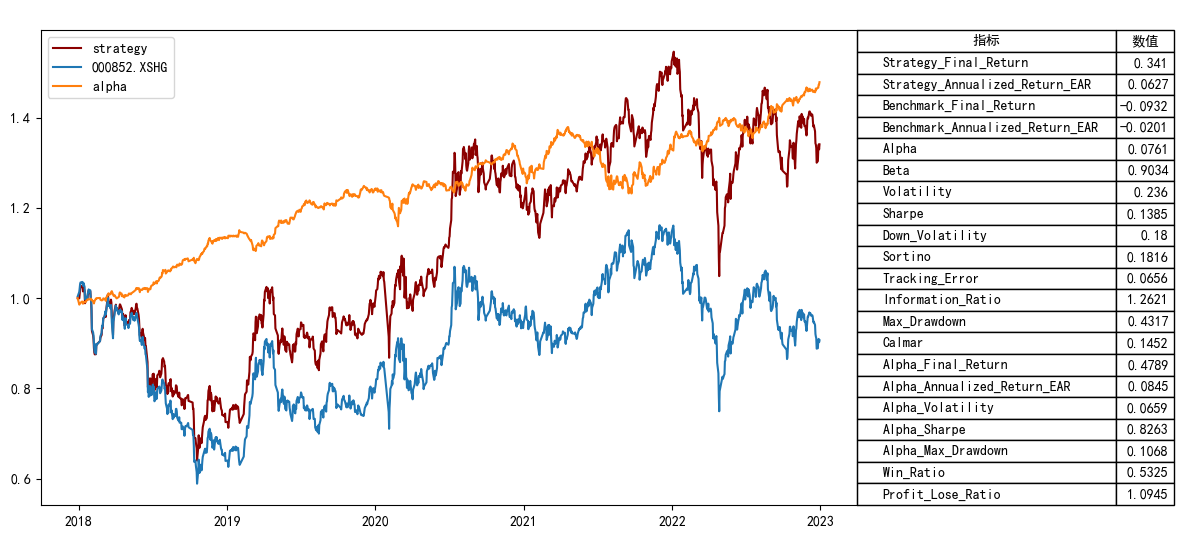

In [37]:
df = ew_combo
buy_list = get_buy_list(df,rank_n = 200)
df_weight = buy_list.div(buy_list.sum(axis = 1),axis = 0)
account_result = backtest(df_weight)
performance_result = get_performance_analysis(account_result,benchmark_index = index_item)

#### 5.2 ICIR加权

In [38]:
icir_combo_value = pd.DataFrame(index = value_dict[factor_names[0]].stack().index) 
for i in tqdm(factor_names):
    icir_combo_value[i] = value_dict[i].stack()

icir_combo_value.index.names = ['datetime','order_book_id']
icir_combo_value.sort_index(inplace = True)

100%|██████████| 7/7 [00:00<00:00,  7.26it/s]


In [39]:
icirw = (ic_df.rolling(240).mean()/ic_df.rolling(240).std())#.shift(20).dropna(how = 'all')
icirw.index.names = ['datetime']
icirw_combo = icir_combo_value.mul(icirw[factor_names],axis = 0).dropna(how = 'all').sum(axis = 1).unstack('order_book_id')
ic,performance = Quick_Factor_Return_N_IC(icirw_combo,20,index_item,'icirw_combo')

{'name': 'icirw_combo', 'IC mean': 0.0974, 'IC std': 0.0817, 'IR': 1.1917, 'IR_ly': 1.2488, 'IC>0': 0.8803, 'ABS_IC>2%': 0.9274, 't_stat': 36.4584}


100%|██████████| 48/48 [00:00<00:00, 250.00it/s]


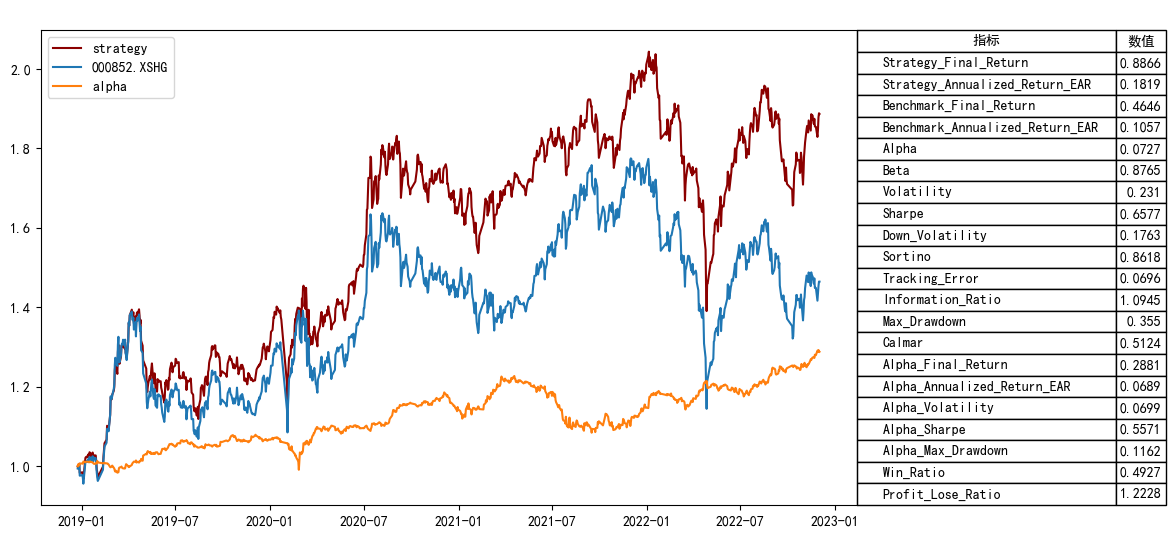

In [40]:
df = icirw_combo
buy_list = get_buy_list(df,rank_n = 200)
df_weight = buy_list.div(buy_list.sum(axis = 1),axis = 0)
account_result = backtest(df_weight)
performance_result = get_performance_analysis(account_result,benchmark_index = index_item)

In [41]:
icirw = (ic_df.rolling(240).mean()/ic_df.rolling(240).std()).shift(20).dropna(how = 'all')
icirw.index.names = ['datetime']
icirw_combo = icir_combo_value.mul(icirw[factor_names],axis = 0).dropna(how = 'all').sum(axis = 1).unstack('order_book_id')
ic,performance = Quick_Factor_Return_N_IC(icirw_combo,20,index_item,'icirw_combo')

{'name': 'icirw_combo', 'IC mean': 0.091, 'IC std': 0.083, 'IR': 1.0968, 'IR_ly': 1.0945, 'IC>0': 0.8686, 'ABS_IC>2%': 0.9113, 't_stat': 33.5543}


100%|██████████| 48/48 [00:00<00:00, 246.60it/s]


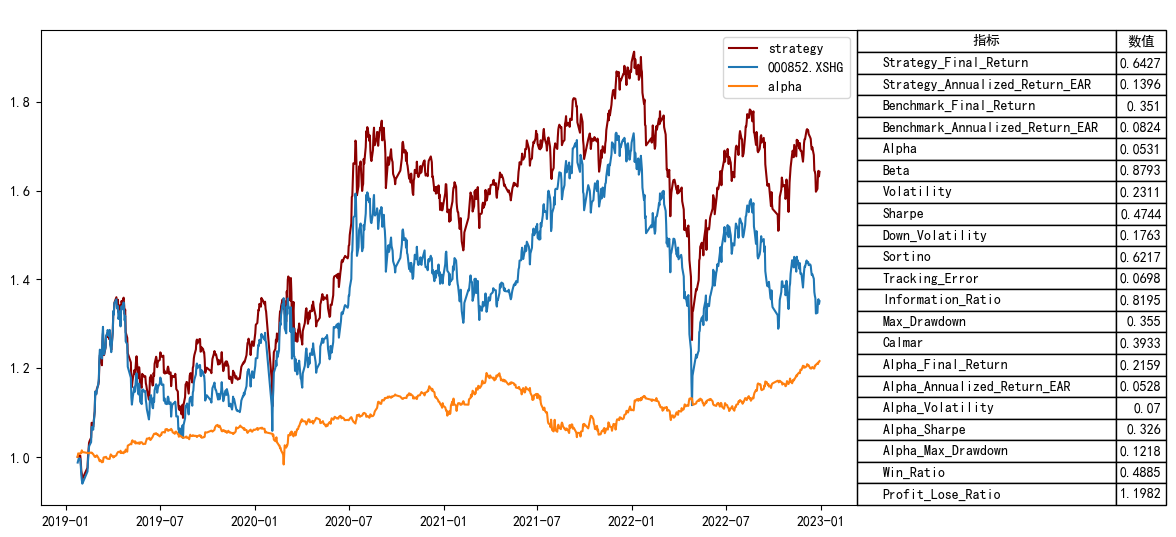

In [42]:
df = icirw_combo
buy_list = get_buy_list(df,rank_n = 200)
df_weight = buy_list.div(buy_list.sum(axis = 1),axis = 0)
account_result = backtest(df_weight)
performance_result = get_performance_analysis(account_result,benchmark_index = index_item)

In [43]:
# 对比同期等权合成
ic,performance = Quick_Factor_Return_N_IC(ew_combo.loc[icirw_combo.index],20,index_item,'ew_combo')

{'name': 'ew_combo', 'IC mean': 0.0954, 'IC std': 0.0829, 'IR': 1.1511, 'IR_ly': 1.2029, 'IC>0': 0.8718, 'ABS_IC>2%': 0.9049, 't_stat': 35.2167}


100%|██████████| 48/48 [00:00<00:00, 263.74it/s]


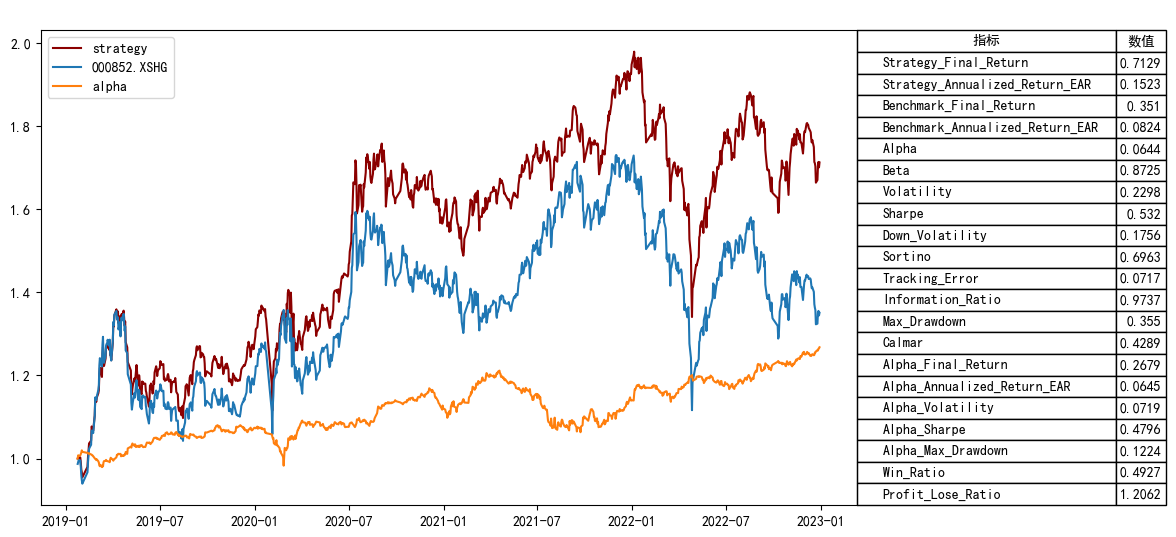

In [44]:
df = ew_combo.loc[icirw_combo.index]
buy_list = get_buy_list(df,rank_n = 200)
df_weight = buy_list.div(buy_list.sum(axis = 1),axis = 0)
account_result = backtest(df_weight)
performance_result = get_performance_analysis(account_result,benchmark_index = index_item)